# Validation: Testing uninformative priors on each CM

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* tests the effect of an uninformative prior on each CM reduction separately

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

Run univariate analysis for the countermeasure, using and uninformative prior

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 General curfew - strict                    0.000 ... 0.213 ... 1.000 ... [0. 1.]


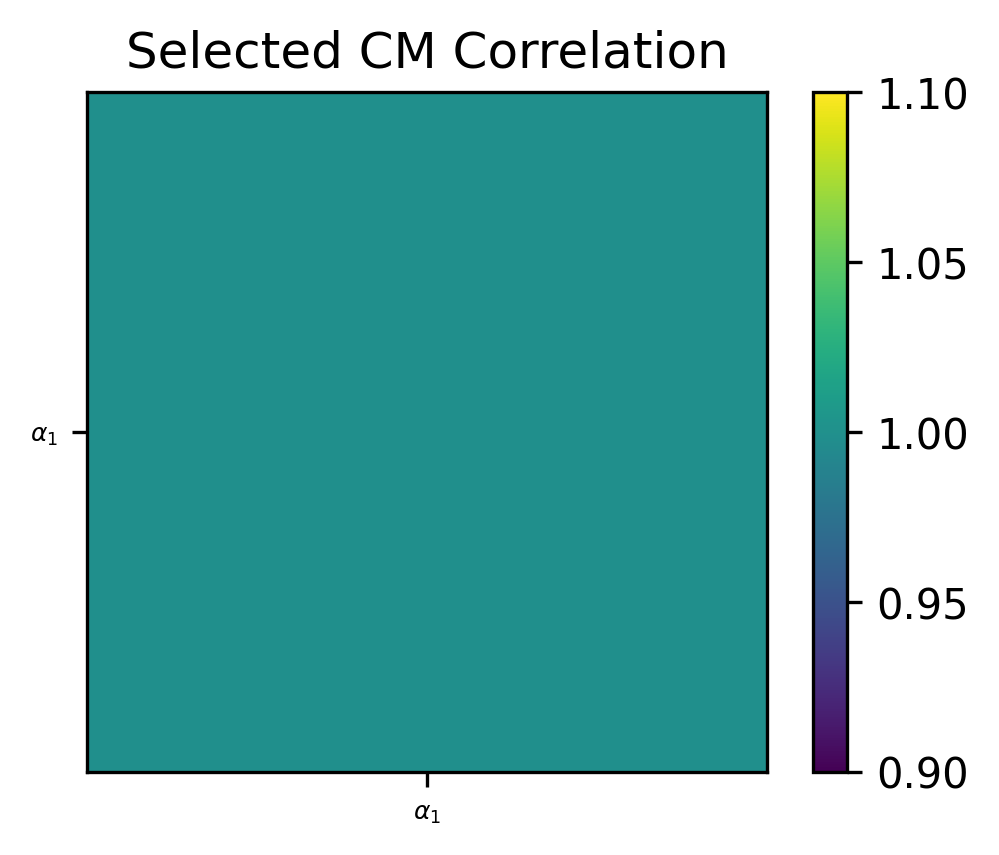

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 11 Regions: f['AT', 'BE', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'IT', 'NO', 'SE']
/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:__main__:Checking model test point
INFO:__main__:
CMReduction_log__             0.00
RegionGrowthRate_log__       -0.03
RegionNoiseScale_log__      -10.11
Growth_log__               1029.54
InitialSize_log__           -35.44
Observed_missing              0.00
Observed                 -20437.23
Name: Log-probability of test_point, dtype: float64

Only 10 samples in chain.
Auto-assigning N

CMReduction_log__             0.00
RegionGrowthRate_log__       -0.03
RegionNoiseScale_log__      -10.11
Growth_log__               1029.54
InitialSize_log__           -35.44
Observed_missing              0.00
Observed                 -20437.23
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, Growth, RegionNoiseScale, RegionGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences:   3%|▎         | 26/1020 [00:07<05:00,  3.30draws/s]


ValueError: Not enough samples to build a trace.

In [17]:
regions = ["AT", "BE", "DK", "FR", "DE", "IT", "NO", "ES", "SE", "CH", "GB"]

all_features = [['General curfew - strict'], # similar to lockdown?
                ['Gatherings limited to 10'], # similar to public events
                ['Schools and universities closed'], # similar to school closure
                ['Asymptomatic contact isolation'], # similar to self-isolation
                ['Distancing and hygiene over 0.2'] # similar to social distancing
               ]

univar_models = []
prior = 'flat' 
for feature in all_features:
    dp = DataPreprocessor()
    data = dp.preprocess_data("../../data", regions, feature)

    with cm_effect.models.CMModelFlexibleV3p1(data) as model:
        if prior == 'default':
            model.build_cm_reduction_exp_gamma_prior()
        if prior == 'wide':
            model.CM_Alpha = pm.Normal("CM_Alpha", 0.5, 10, shape=(model.nCMs,))
            model.Det("CMReduction", T.exp((-1.0) * model.CM_Alpha))
        if prior == 'wider':
            model.CM_Alpha = pm.Normal("CM_Alpha", 0.5, 100, shape=(model.nCMs,))
            model.Det("CMReduction", T.exp((-1.0) * model.CM_Alpha))
        if prior == 'flat':
            model.CM_Alpha = pm.Flat("CM_Alpha", shape=(model.nCMs,))
            model.Det("CMReduction", T.exp((-1.0) * model.CM_Alpha))
        if prior == 'vague':
            model.build_cm_reduction_exp_gamma_prior(alpha= 0.001, beta= 0.001) 
            
        model.build_region_growth_prior()
        model.build_region_reliability_prior()
        model.build_rates()
        model.build_output_model()
        log.info("Checking model test point")
        log.info(f"\n{model.check_test_point()}\n")
    
    model.run(10)
    model.plot_traces()
    univar_models.append(model)

In [15]:
def plot_cm_univariate(models):
    fig = plt.figure()
    plt.rc('font', size=15)
    means = []
    for model in models:
        means.append(np.mean(model.trace["CMReduction"]))
    N_cms = len(models)
    plt.plot([1, 1], [1, -(N_cms)], "--r", linewidth=0.5)
    y_vals = -1 * np.arange(N_cms)
    plt.scatter(means, y_vals, marker="|", color='k')

    for i in range(len(models)):
        li = np.percentile(models[i].trace["CMReduction"], 2.5)
        ui = np.percentile(models[i].trace["CMReduction"], 97.5)
        lq = np.percentile(models[i].trace["CMReduction"], 25)
        uq = np.percentile(models[i].trace["CMReduction"], 75)
        plt.plot([li, ui], [y_vals[i], y_vals[i]], "k", alpha=0.25)
        plt.plot([lq, uq], [y_vals[i], y_vals[i]], "k", alpha=0.5)
 
    #plt.xlim([0.5, 2])
    plt.ylim([-(N_cms - 0.5), 0.5])
    plt.ylabel("Countermeasure")
    #plt.yticks(y_vals, [f"$\\alpha_{{{i + 1}}}$" for i in range(N_cms)])
    plt.yticks(y_vals, all_features)
    plt.xlabel("Countermeasure Effectiveness")
    plt.savefig('out/cm_univariate_prior_sensitivity.pdf')

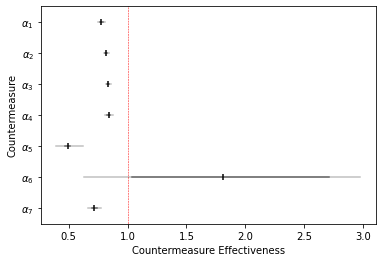

In [78]:
plot_cm_univariate(univar_models)